In [1]:
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps, os
import tensorflow as tf
dataDir = "/home/nirvan/Desktop/github/GeoguessrAI/infoExtraction/data"
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import decode_predictions

In [2]:
def plotMap(polyGrid, Loc, restrict=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    if len(restrict)==0:
        restrict = list(polyGrid.keys())
        
    for k,v in Loc.items():
        if k in restrict:
            gPoly.append(gmaps.Polygon(
                            list(polyGrid[k]),
                            stroke_color='red',
                            fill_color='blue'
                            ))
            sLoc += v
            sHtext += [str(k)+str(i) for i in v]
        
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

243


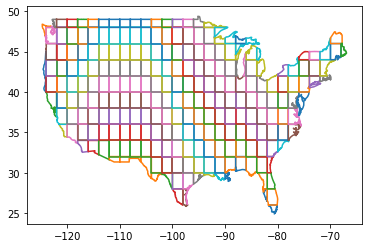

In [3]:
usaPolyGrid = pickle.load(open("/home/nirvan/Desktop/github/GeoguessrAI/infoExtraction/usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolyGrid))

# Load Data

In [3]:
dataSplits = {}
for g in os.listdir(dataDir+'/dataSplit'):
    dataSplits[g.split('.')[0]] = np.load(dataDir+'/dataSplit/'+g)

In [4]:
X = []
y = []
for xi,yi in zip(dataSplits['0_3000'][0][0:500],dataSplits['0_3000'][1][0:500]):
    X.append(plt.imread(dataDir+'/dataCombined/'+xi))
    y.append(int(yi))

In [5]:
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical(y, dtype='float32')

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(300,600,3)))
# model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(243, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

In [6]:
model.fit(X,y,epochs=10)

ValueError: A target array with shape (500, 243) was passed for an output of shape (None, 298, 598, 243) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [8]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(300,600,3))
model_finetuned = tf.keras.models.Sequential()
model_finetuned.add(restnet)
model_finetuned.add(tf.keras.layers.GlobalAveragePooling2D())
model_finetuned.add(tf.keras.layers.Dense(243, activation="softmax"))
model_finetuned.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model_finetuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 243)               497907    
Total params: 24,085,619
Trainable params: 24,032,499
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_finetuned.fit(X,y,epochs=10)

Train on 500 samples
Epoch 1/10


In [4]:
gdsLoc = {}
X = []
y = []
for g in os.listdir(dataDir):
    gdsLoc[int(g)] = []
    for loc in os.listdir(dataDir + "/{}".format(g)):
        gdsLoc[int(g)].append(list(map(lambda x:float(x),loc.split(','))))
        for img in os.listdir(dataDir + "/{}/{}".format(g,loc)):
            image = plt.imread(dataDir + "/{}/{}/{}".format(g,loc,img))
            X.append(image)
            y.append(int(g))

In [26]:
plotMap(usaPolyGrid, gdsLoc, restrict=[])

Figure(layout=FigureLayout(height='420px'))

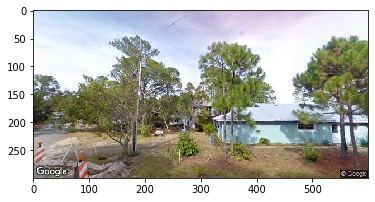

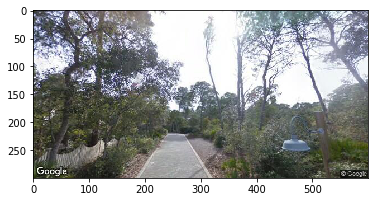

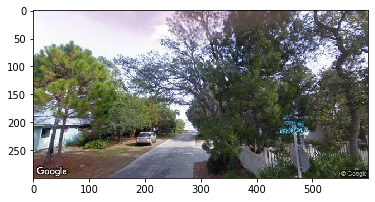

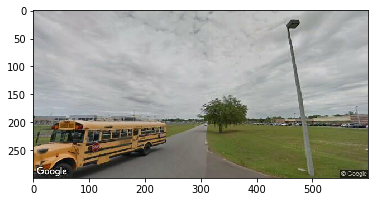

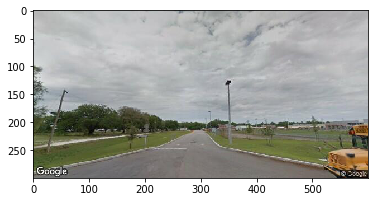

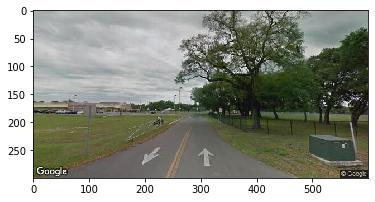

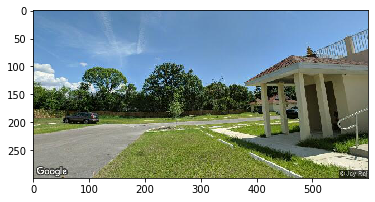

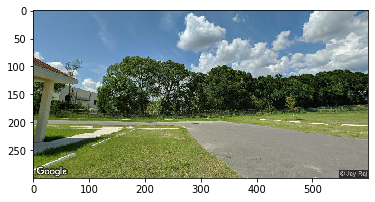

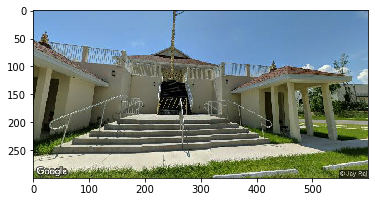

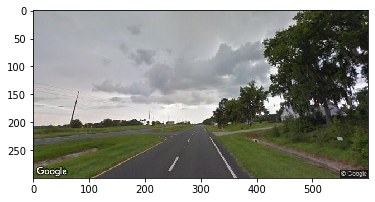

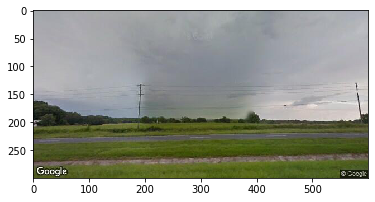

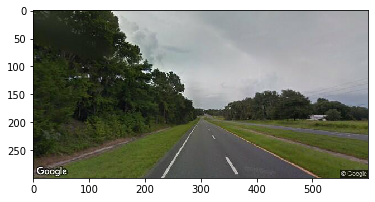

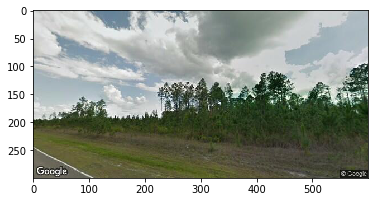

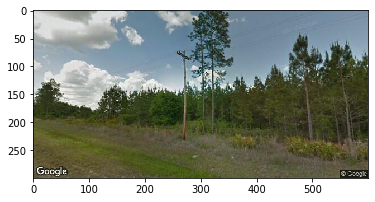

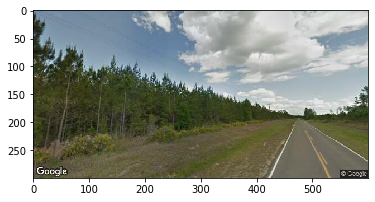

In [30]:
for x_i,y_i in zip(X,y):
    if y_i==201:
        plt.imshow(x_i)
        plt.show()

In [28]:
image = plt.imread(dataDir+'/dataCombined/'+dataSplits['0_3000'][0][0])

In [33]:
dataSplits['0_3000'][0][0]

'93+33.75872141156668,-103.6481513668773+180_2008-02.jpg'

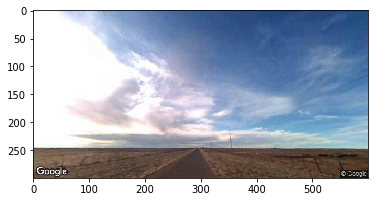

In [30]:
plt.imshow(image)

# Resnet model training

[[('n09468604', 'valley', 0.12930165),
  ('n09193705', 'alp', 0.098877706),
  ('n03792782', 'mountain_bike', 0.0563612),
  ('n09246464', 'cliff', 0.040078383),
  ('n03594945', 'jeep', 0.029248074)]]

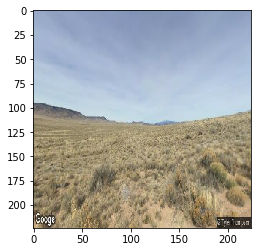

In [9]:
image = np.array(load_img(dataDir+'/dataCombined/'+dataSplits['0_3000'][0][6], target_size=(224, 224)))
plt.imshow(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
restnetTest = ResNet50(include_top=True, weights='imagenet', input_shape=(224,224,3))
decode_predictions(restnetTest.predict(image))

array([[0.09292044, 0.05844638, 0.05083472, 0.04854777, 0.02073484,
        0.13043383, 0.28638873, 0.0540205 , 0.20170388, 0.05596889]],
      dtype=float32)

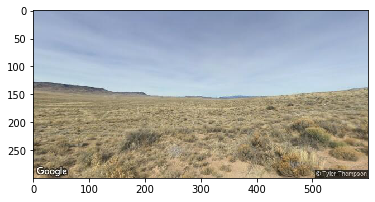

In [88]:
image = np.array(load_img(dataDir+'/dataCombined/'+dataSplits['0_3000'][0][6]))
plt.imshow(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(300,600,3))
model_finetuned = tf.keras.models.Sequential()
model_finetuned.add(restnet)
model_finetuned.add(tf.keras.layers.GlobalAveragePooling2D())
model_finetuned.add(tf.keras.layers.Dense(10, activation="softmax"))
model_finetuned.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model_finetuned.predict(image)

In [86]:
model_finetuned.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [84]:
restnetTest.get_layer('avg_pool')

In [52]:
restnetTest.get_layer('avg_pool')

In [55]:
restnetTest.get_layer('probs')

In [56]:
restnetTest.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [58]:
tf.keras.layers.Dense(10, activation="softmax")

In [77]:
o1 = list(map(lambda x:int(x), dataSplits['0_3000'][1]))
o = tf.keras.utils.to_categorical(o1, dtype='float32')